In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
from tess_sip import SIP
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import transitleastsquares as tls

%config InlineBackend.print_figure_kwargs={"facecolor" : "w"}

In [2]:
srs = lk.search_lightcurve("WASP50", author="TESS-SPOC")
display(srs)
lcs = srs.download_all(flux_column="pdcsap_flux")

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 04,2018,TESS-SPOC,1800,382391899,0.0
1,TESS Sector 31,2020,TESS-SPOC,600,382391899,0.0


In [ ]:
def check_cols(lc):
    print(lc.flux[0], lc.pdcsap_flux[0] / np.median(lc.pdcsap_flux))

In [3]:
binsize = 0.5
lcs_binned = lk.LightCurveCollection(
    [
        data_oot(
            lc.remove_nans("flux").remove_nans("flux_err"),
            period, duration, t_0).flatten()
        .bin(
            time_bin_size=binsize,
        ).remove_nans("flux").remove_nans("flux_err").normalize()
        for lc in lcs
    ]
)

lcs_combined = lcs_binned.stitch()
lcs_combined.to_csv("/home/mango/Desktop/tess.csv", overwrite=True)

NameError: name 'data_oot' is not defined

In [ ]:
lcs_combined.fold()

In [ ]:
pg = lcs_combined.to_periodogram(minimum_period=5, maximum_period=30)

pg.plot()

plt.show()

In [ ]:
pg.period_at_max_power

In [ ]:
lcs_combined.fold(pg.period_at_max_power).scatter()

plt.show()

In [ ]:
check_cols(lcs_binned[1])

In [ ]:
fig, ax = plt.subplots()

i = 1
lcs[i].normalize().scatter(ax=ax)
lcs_binned[i].scatter(ax=ax)


fig

In [87]:
srs_tpfs = lk.search_targetpixelfile("WASP50", exptime=[120, 1800])
display(srs_tpfs)
tpfs = srs_tpfs.download_all()

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 04,2018,SPOC,120,382391899,0.0
1,TESS Sector 04,2018,TESS-SPOC,1800,382391899,0.0
2,TESS Sector 31,2020,SPOC,120,382391899,0.0
3,TESS Sector 31,2020,TESS-SPOC,600,382391899,0.0


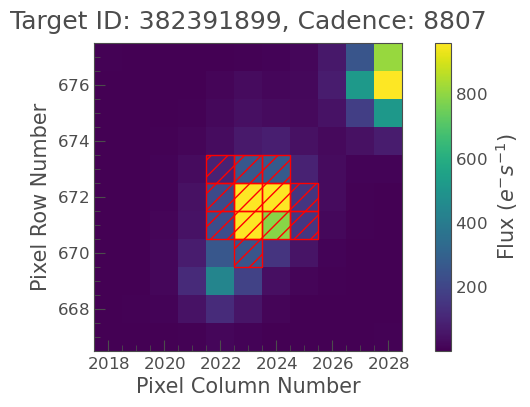

In [92]:
tpfs[1].plot(aperture_mask="pipeline")

plt.show()

In [86]:
lcs_binned[0]

time,flux,flux_err,time_bin_start,time_bin_size,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,electron / s,electron / s,,s,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
object,float64,float64,object,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1411.203531534125,5537.25927734375,2.5482053756713867,1410.953531534125,43200.0,0.005076863802969456,8819,2023.3833130998478,671.6399808904912,5537.25927734375,2.5482053756713867,1320.904052734375,0.9304176568984985,6253.22998046875,2.9805335998535156,23,nan,nan,nan,nan,2023.3833130998478,0.000355714641045779,671.6399808904912,0.0003433976962696761,0.17600663006305695,-0.06429001688957214
1411.703531534125,5547.45751953125,2.5493810176849365,1411.453531534125,43200.0,0.005086527671664953,8842,2023.3844066792815,671.6426686616827,5547.45751953125,2.5493810176849365,1319.2197265625,0.9299769997596741,6256.72802734375,2.9819087982177734,0,nan,nan,nan,nan,2023.3844066792815,0.0003552372509147972,671.6426686616827,0.00034262952976860106,0.177212193608284,-0.06029924377799034
1412.203531534125,5545.4189453125,2.5490188598632812,1411.953531534125,43200.0,0.005095563363283873,8866,2023.3842672085827,671.6448611352271,5545.4189453125,2.5490188598632812,1318.4598388671875,0.9298879504203796,6249.38232421875,2.98148512840271,0,nan,nan,nan,nan,2023.3842672085827,0.00035534464404918253,671.6448611352271,0.0003424024616833776,0.1771044284105301,-0.05696767568588257
1412.703531534125,5545.11474609375,2.5492608547210693,1412.453531534125,43200.0,0.005104072857648134,8890,2023.3838915877216,671.6467298465436,5545.11474609375,2.5492608547210693,1319.5179443359375,0.930175244808197,6251.70458984375,2.9817683696746826,0,nan,nan,nan,nan,2023.3838915877216,0.0003553695569280535,671.6467298465436,0.00034240284003317356,0.17647166550159454,-0.05432426556944847
1413.203531534125,5532.40380859375,2.5477263927459717,1412.953531534125,43200.0,0.005111619830131531,8914,2023.3493256831593,671.6507104491429,5532.40380859375,2.5477263927459717,1321.2366943359375,0.9303461313247681,6237.900390625,2.979973554611206,0,nan,nan,nan,nan,2023.3493256831593,0.00035506871063262224,671.6507104491429,0.00034278869861736894,0.13579688966274261,-0.05110948905348778
1413.703531534125,5537.9052734375,2.5491034984588623,1413.453531534125,43200.0,0.00511859729886055,8938,2023.276703894945,671.6572101869061,5537.9052734375,2.5491034984588623,1323.3306884765625,0.9307536482810974,6247.01611328125,2.9815845489501953,0,nan,nan,nan,nan,2023.276703894945,0.00035265751648694277,671.6572101869061,0.00034242289257235825,0.049548469483852386,-0.047588590532541275
1414.203531534125,5540.20654296875,2.5493056774139404,1413.953531534125,43200.0,0.005125359166413546,8963,2023.2756707591989,671.6588118293477,5540.20654296875,2.5493056774139404,1322.0557861328125,0.930590033531189,6250.99365234375,2.981820583343506,0,nan,nan,nan,nan,2023.2756707591989,0.00035247791674919426,671.6588118293477,0.0003423197485972196,0.0484156459569931,-0.045418355613946915
1414.703531534125,5543.87890625,2.5497350692749023,1414.453531534125,43200.0,0.005130935925990343,8986,2023.2749922161709,671.6606570909785,5543.87890625,2.5497350692749023,1321.8211669921875,0.9305242896080017,6254.20263671875,2.9823226928710938,0,nan,nan,nan,nan,2023.2749922161709,0.00035228891647420824,671.6606570909785,0.000342104205628857,0.04772539064288139,-0.0432736910879612


Running pixels in aperture: 100%|██████████| 400/400 [00:00<00:00, 526.03it/s]


16.30790190735695


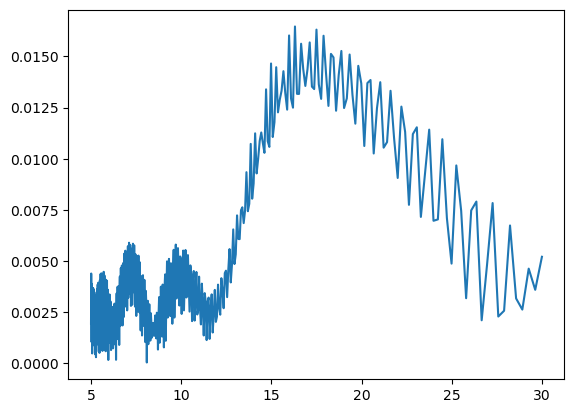

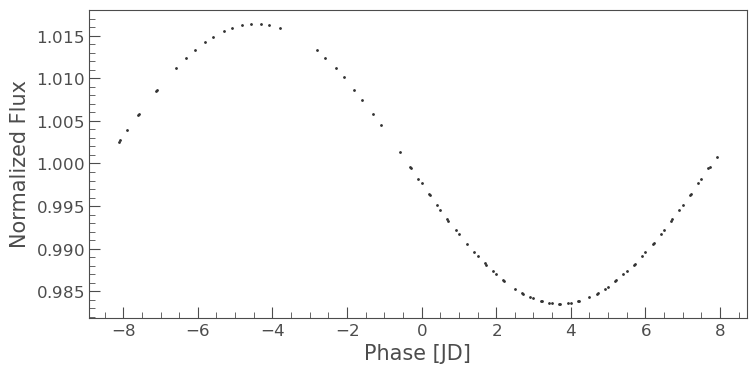

In [61]:
binsize = 0.5
lcs_binned = lk.LightCurveCollection(
    [lcs[0].bin(binsize), lcs[1].bin(binsize)]
)

sip_kwargs = {
    "min_period": 5.0,
    "max_period": 30.0,
    "nperiods": 400,
    #"bin_kwargs": {"time_bin_size": 12.0*u.hr.to("d")},
}

r = SIP(lcs_binned, **sip_kwargs)

l_corr = data_oot(r["corr_lc"], period, duration, t_0)

P_max = r["period_at_max_power"]
#P_max = r["periods"][np.argmax(p_div)]
#p_div = r["power"]/r["power_bkg"]
p_div = r["power"]

plt.plot(r["periods"], p_div)
#plt.axvline(P_max, "r--")

print(P_max)

l_corr.fold(P_max).scatter()

plt.show()

In [85]:
P_max

16.30790190735695

In [78]:
r["corr_lc"].to_csv("/home/mango/Desktop/tess.csv")

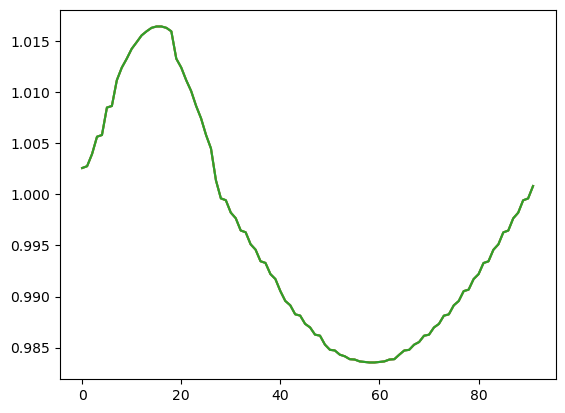

In [84]:
f = l_corr.fold(P_max).flux.value

np.median

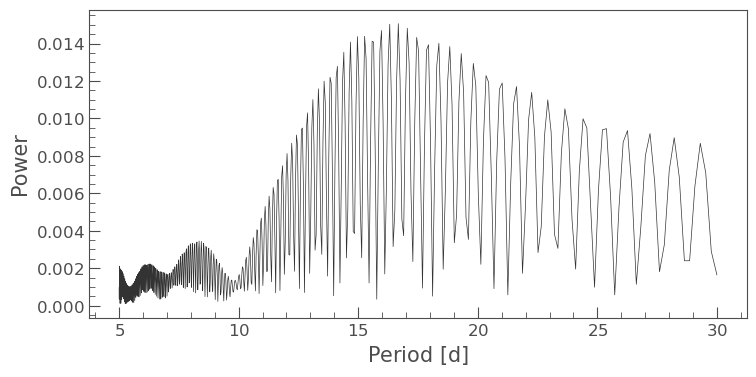

In [76]:
pg = r["corr_lc"].to_periodogram(minimum_period=5, maximum_period=30)

pg.plot()

plt.show()

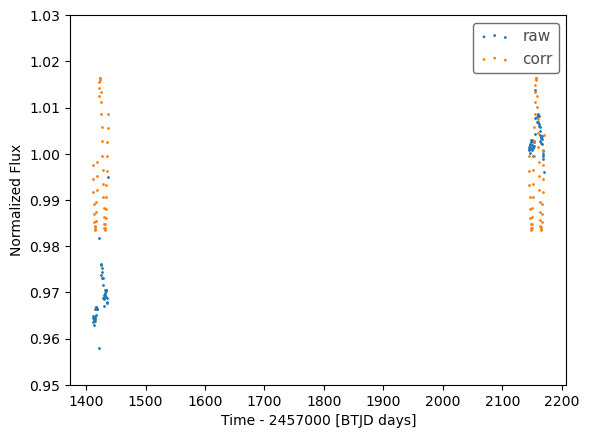

In [71]:
fig, ax = plt.subplots()

#data_oot(lcs.stitch(), period, duration, t_0).scatter(ax=ax, label="raw")
#data_oot(l_corr, period, duration, t_0).scatter(ax=ax, label="corrected")

#plt.xlim(1400, 1450)
#plt.xlim(2100, 2200)

r["raw_lc"].scatter(ax=ax, label="raw")
r["corr_lc"].scatter(ax=ax, label="corr")

#ax.set_xlim(1400, 1450)
ax.set_ylim(0.95, 1.03)

plt.show()

In [4]:
period = 1.9550931258
t_0 = 2455558.61237 
duration = 1.1 * 1.83 * (1.0 / 24.0) # 1.1x buffer

def data_oot(lc, period, duration, t_0):
    in_transit = tls.transit_mask(lc.time.jd, period, duration, t_0)
    return lc[~in_transit]

In [5]:
import pandas as pd

In [ ]:
lcs_binned.stitch().to_csv("/home/mango/Desktop/tess.csv", overwrite=True)

In [39]:
pg = lc.to_periodogram(minimum_period=5, maximum_period=30)

pg.plot()

P_max = pg.period_at_max_power
print(P_max)

plt.show()

NameError: name 'lc' is not defined

In [ ]:
pg._LS_object.false_alarm_probability(0.0014, method="davies")

In [ ]:
pg._LS_object.false_alarm_probability(0.0014)

In [ ]:
fig, ax = plt.subplots()

lc_folded = lc.fold(P_max)#.remove_outliers(sigma=3)

lc_folded.scatter(ax=ax)
#lc_folded.bin(0.2).scatter(ax=ax, marker="x")

#plt.ylim(0.995, 1.005)

plt.show()